In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

# Import from toy_model
from toy_model.state_event_model import *
from toy_model.state_event_generator import StateEventGenerator
from toy_model.velo_workflow import make_detector

try:
    import dill as _pickle
except ImportError:
    import pickle as _pickle

# Setup
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

# System-agnostic paths - relative to notebook
NOTEBOOK_DIR = Path.cwd()
BASE = NOTEBOOK_DIR.parent / 'data' / 'segment_analysis'
FIXED_EPS_RUNS = BASE / 'runs_fixed_epsilon'
PLOTS_DIR = BASE / 'plots'

# Create directories
BASE.mkdir(parents=True, exist_ok=True)
FIXED_EPS_RUNS.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f'Notebook directory: {NOTEBOOK_DIR}')
print(f'Base directory: {BASE}')
print(f'Output directory: {FIXED_EPS_RUNS}')

In [ ]:

# Output directory for fixed epsilon study
FIXED_EPS_RUNS = BASE / 'runs_fixed_epsilon'

# Create directory if it doesn't exist (don't delete existing data!)
FIXED_EPS_RUNS.mkdir(parents=True, exist_ok=True)

# Fixed parameters
FIXED_RESOLUTION = 0.005      # 5 µm
FIXED_SCATTERING = 0.0001     # 0.1 mrad in radians
FIXED_EPSILON = 0.002         # 2 mrad in radians (FIXED, not calculated)
TRACKS_PER_EVENT = 20
EVENT_COUNTS = list(range(1, 11))  # 1 to 10 events (20 to 200 tracks)
N_REPEATS = 10

print("FIXED EPSILON EXPERIMENT CONFIGURATION")
print("="*60)
print(f"Resolution σ_res:     {FIXED_RESOLUTION*1000:.0f} µm")
print(f"Scattering σ_scatt:   {FIXED_SCATTERING*1000:.2f} mrad")
print(f"Epsilon (FIXED):      {FIXED_EPSILON*1000:.1f} mrad")
print(f"Tracks per event:     {TRACKS_PER_EVENT}")
print(f"Event counts:         {EVENT_COUNTS} ({TRACKS_PER_EVENT} to {TRACKS_PER_EVENT*max(EVENT_COUNTS)} tracks)")
print(f"Repeats per config:   {N_REPEATS}")
print(f"Total batches:        {len(EVENT_COUNTS) * N_REPEATS}")
print(f"\nOutput directory:     {FIXED_EPS_RUNS}")
print("="*60)

FIXED EPSILON EXPERIMENT CONFIGURATION
Resolution σ_res:     5 µm
Scattering σ_scatt:   0.10 mrad
Epsilon (FIXED):      2.0 mrad
Tracks per event:     20
Event counts:         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] (20 to 200 tracks)
Repeats per config:   10
Total batches:        100

Output directory:     /Users/xenofonchiotopoulos/Desktop/PHD_STUFF/OneBQF/data/segment_analysis/runs_fixed_epsilon


In [ ]:
def compute_segment_angles_from_event(event):
    """Compute angles between segments from an event."""
    true_angles = []
    false_angles = []
    
    all_segments = []
    segment_to_track = {}
    
    for track in event.tracks:
        for seg in track.segments:
            all_segments.append(seg)
            segment_to_track[id(seg)] = track.track_id
    
    if len(all_segments) < 2:
        return true_angles, false_angles
    
    for i in range(len(all_segments)):
        for j in range(i + 1, len(all_segments)):
            seg_i = all_segments[i]
            seg_j = all_segments[j]
            
            vec_i = np.array(seg_i.to_vect())
            vec_j = np.array(seg_j.to_vect())
            
            norm_i = np.linalg.norm(vec_i)
            norm_j = np.linalg.norm(vec_j)
            
            if norm_i == 0 or norm_j == 0:
                continue
            
            vec_i = vec_i / norm_i
            vec_j = vec_j / norm_j
            
            cos_angle = np.clip(np.dot(vec_i, vec_j), -1.0, 1.0)
            angle = np.arccos(cos_angle)
            
            track_i = segment_to_track.get(id(seg_i))
            track_j = segment_to_track.get(id(seg_j))
            
            if track_i == track_j:
                true_angles.append(angle)
            else:
                false_angles.append(angle)
    
    return true_angles, false_angles

# Save/load path
FIXED_EPS_RUNS.mkdir(parents=True, exist_ok=True)
angle_data_path = FIXED_EPS_RUNS / 'fixed_epsilon_angle_data_v3.pkl'

# Track counts: 20-200 in steps of 20
QUICK_EVENT_COUNTS = list(range(1, 11))

if angle_data_path.exists():
    print("="*80)
    print("LOADING SAVED ANGLE DATA")
    print("="*80)
    with open(angle_data_path, 'rb') as f:
        saved_data = pickle.load(f)
    fixed_eps_angle_results = saved_data['fixed_eps_angle_results']
    print(f"✓ Loaded {len(fixed_eps_angle_results)} configurations from: {angle_data_path}")
else:
    print("="*80)
    print("GENERATING ANGLE DATA")
    print("="*80)
    
    Detector = make_detector()
    fixed_eps_angle_results = []
    
    start_time = time.time()
    for n_events in QUICK_EVENT_COUNTS:
        total_tracks = n_events * TRACKS_PER_EVENT
        
        if total_tracks <= 100:
            n_repeats = 50
        else:
            n_repeats = 10
        
        print(f"\n[{n_events} events = {total_tracks} tracks] ({n_repeats} repeats)", end=" ")
        
        per_repeat_data = []
        all_true_angles = []
        all_false_angles = []
        n_particles_per_event = [TRACKS_PER_EVENT] * n_events
        
        for repeat in range(n_repeats):
            np.random.seed(repeat + n_events * 1000)
            
            seg = StateEventGenerator(
                Detector,
                phi_min=-0.2,
                phi_max=0.2,
                events=n_events,
                n_particles=n_particles_per_event,
                measurement_error=float(FIXED_RESOLUTION),
                collision_noise=float(FIXED_SCATTERING),
            )
            
            seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})
            
            event_particles = [
                [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_tracks)]
                for _ in range(n_events)
            ]
            seg.generate_particles(event_particles)
            event = seg.generate_complete_events()
            
            true_angles, false_angles = compute_segment_angles_from_event(event)
            
            per_repeat_data.append({
                'n_true': len(true_angles),
                'n_false': len(false_angles),
                'true_accepted': np.sum(np.array(true_angles) <= FIXED_EPSILON) if len(true_angles) > 0 else 0,
                'false_accepted': np.sum(np.array(false_angles) <= FIXED_EPSILON) if len(false_angles) > 0 else 0,
            })
            
            all_true_angles.extend(true_angles)
            all_false_angles.extend(false_angles)
        
        if len(all_true_angles) > 0:
            fixed_eps_angle_results.append({
                'n_events': n_events,
                'total_tracks': total_tracks,
                'true_angles': np.array(all_true_angles),
                'false_angles': np.array(all_false_angles),
                'n_true': len(all_true_angles),
                'n_false': len(all_false_angles),
                'per_repeat_data': per_repeat_data,
            })
            
            print(f"✓ {len(all_true_angles)} true, {len(all_false_angles)} false pairs")
    
    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"Generated {len(fixed_eps_angle_results)} configurations in {elapsed:.1f}s")
    
    # Save data
    with open(angle_data_path, 'wb') as f:
        pickle.dump({
            'fixed_eps_angle_results': fixed_eps_angle_results,
            'FIXED_EPSILON': FIXED_EPSILON,
            'FIXED_RESOLUTION': FIXED_RESOLUTION,
            'FIXED_SCATTERING': FIXED_SCATTERING,
            'TRACKS_PER_EVENT': TRACKS_PER_EVENT,
        }, f)
    print(f"✓ Data saved to: {angle_data_path}")

GENERATING ANGLE DATA

[1 events = 20 tracks] (50 repeats) ✓ 6000 true, 152000 false pairs

[2 events = 40 tracks] (50 repeats) ✓ 12000 true, 624000 false pairs

[3 events = 60 tracks] (50 repeats) ✓ 18000 true, 1416000 false pairs

[4 events = 80 tracks] (50 repeats) ✓ 24000 true, 2528000 false pairs

[5 events = 100 tracks] (50 repeats) ✓ 30000 true, 3960000 false pairs

[6 events = 120 tracks] (10 repeats) ✓ 7200 true, 1142400 false pairs

[7 events = 140 tracks] (10 repeats) ✓ 8400 true, 1556800 false pairs

[8 events = 160 tracks] (10 repeats) ✓ 9600 true, 2035200 false pairs

[9 events = 180 tracks] (10 repeats) ✓ 10800 true, 2577600 false pairs

[10 events = 200 tracks] (10 repeats) ✓ 12000 true, 3184000 false pairs

Generated 10 configurations in 176.7s
✓ Data saved to: /Users/xenofonchiotopoulos/Desktop/PHD_STUFF/OneBQF/data/segment_analysis/runs_fixed_epsilon/fixed_epsilon_angle_data_v3.pkl


In [9]:
# ============================================================================
# SEGMENT EFFICIENCY: Direct computation from angle data (with per-repeat stats)
# ============================================================================
# Use the angle data we already collected to compute segment-level efficiency
# 
# A segment PAIR is "selected" if the angle between segments ≤ epsilon
# True pairs: pairs from same track (should be selected)
# False pairs: pairs from different tracks (should not be selected)
#
# Segment Efficiency = N_true_pairs_accepted / N_true_pairs
# Segment False Rate = N_false_pairs_accepted / N_all_pairs_accepted

print("="*80)
print("SEGMENT-LEVEL EFFICIENCY (from angle thresholding)")
print("="*80)
print(f"Epsilon threshold: {FIXED_EPSILON*1000:.1f} mrad")
print("="*80)

segment_efficiency_results = []

for result in fixed_eps_angle_results:
    true_angles = result['true_angles']
    false_angles = result['false_angles']
    
    # Count pairs accepted (angle ≤ epsilon) - aggregated
    true_accepted = np.sum(true_angles <= FIXED_EPSILON)
    false_accepted = np.sum(false_angles <= FIXED_EPSILON)
    
    n_true = len(true_angles)
    n_false = len(false_angles)
    n_all_accepted = true_accepted + false_accepted
    
    # Segment Efficiency = true pairs found / all true pairs
    seg_efficiency = true_accepted / n_true if n_true > 0 else 0.0
    
    # Segment False Rate = false pairs accepted / all pairs accepted
    seg_false_rate = false_accepted / n_all_accepted if n_all_accepted > 0 else 0.0
    
    # Extract per-repeat data if available
    per_repeat_data = result.get('per_repeat_data', None)
    
    if per_repeat_data:
        # Compute mean and std for per-repeat quantities
        n_true_per_repeat = np.array([r['n_true'] for r in per_repeat_data])
        n_false_per_repeat = np.array([r['n_false'] for r in per_repeat_data])
        true_acc_per_repeat = np.array([r['true_accepted'] for r in per_repeat_data])
        false_acc_per_repeat = np.array([r['false_accepted'] for r in per_repeat_data])
        
        n_repeats = len(per_repeat_data)
        
        # Standard errors (std / sqrt(n))
        n_true_mean = np.mean(n_true_per_repeat)
        n_true_se = np.std(n_true_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        n_false_mean = np.mean(n_false_per_repeat)
        n_false_se = np.std(n_false_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        true_acc_mean = np.mean(true_acc_per_repeat)
        true_acc_se = np.std(true_acc_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        false_acc_mean = np.mean(false_acc_per_repeat)
        false_acc_se = np.std(false_acc_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
    else:
        # No per-repeat data - use aggregated values with zero errors
        n_true_mean = n_true
        n_true_se = 0
        n_false_mean = n_false
        n_false_se = 0
        true_acc_mean = true_accepted
        true_acc_se = 0
        false_acc_mean = false_accepted
        false_acc_se = 0
        n_repeats = 1
    
    segment_efficiency_results.append({
        'n_events': result['n_events'],
        'total_tracks': result['total_tracks'],
        'n_true_pairs': n_true,
        'n_false_pairs': n_false,
        'true_accepted': true_accepted,
        'false_accepted': false_accepted,
        'total_accepted': n_all_accepted,
        'seg_efficiency': seg_efficiency,
        'seg_false_rate': seg_false_rate,
        # Per-repeat statistics for error bars
        'n_true_mean': n_true_mean,
        'n_true_se': n_true_se,
        'n_false_mean': n_false_mean,
        'n_false_se': n_false_se,
        'true_acc_mean': true_acc_mean,
        'true_acc_se': true_acc_se,
        'false_acc_mean': false_acc_mean,
        'false_acc_se': false_acc_se,
        'n_repeats': n_repeats,
    })
    
    print(f"\n[{result['total_tracks']} tracks] ({n_repeats} repeats)")
    print(f"  True pairs: {n_true_mean:.0f} ± {n_true_se:.1f}, accepted: {true_acc_mean:.0f} ± {true_acc_se:.1f}")
    print(f"  False pairs: {n_false_mean:.0f} ± {n_false_se:.1f}, accepted: {false_acc_mean:.0f} ± {false_acc_se:.1f}")
    print(f"  → Segment Efficiency: {seg_efficiency*100:.1f}%")
    print(f"  → False Rate: {seg_false_rate*100:.2f}%")

print(f"\n{'='*80}")
print("SEGMENT EFFICIENCY ANALYSIS COMPLETE")
print(f"{'='*80}")# ============================================================================
# SEGMENT EFFICIENCY: Direct computation from angle data (with per-repeat stats)
# ============================================================================
# Use the angle data we already collected to compute segment-level efficiency
# 
# A segment PAIR is "selected" if the angle between segments ≤ epsilon
# True pairs: pairs from same track (should be selected)
# False pairs: pairs from different tracks (should not be selected)
#
# Segment Efficiency = N_true_pairs_accepted / N_true_pairs
# Segment False Rate = N_false_pairs_accepted / N_all_pairs_accepted

print("="*80)
print("SEGMENT-LEVEL EFFICIENCY (from angle thresholding)")
print("="*80)
print(f"Epsilon threshold: {FIXED_EPSILON*1000:.1f} mrad")
print("="*80)

segment_efficiency_results = []

for result in fixed_eps_angle_results:
    true_angles = result['true_angles']
    false_angles = result['false_angles']
    
    # Count pairs accepted (angle ≤ epsilon) - aggregated
    true_accepted = np.sum(true_angles <= FIXED_EPSILON)
    false_accepted = np.sum(false_angles <= FIXED_EPSILON)
    
    n_true = len(true_angles)
    n_false = len(false_angles)
    n_all_accepted = true_accepted + false_accepted
    
    # Segment Efficiency = true pairs found / all true pairs
    seg_efficiency = true_accepted / n_true if n_true > 0 else 0.0
    
    # Segment False Rate = false pairs accepted / all pairs accepted
    seg_false_rate = false_accepted / n_all_accepted if n_all_accepted > 0 else 0.0
    
    # Extract per-repeat data if available
    per_repeat_data = result.get('per_repeat_data', None)
    
    if per_repeat_data:
        # Compute mean and std for per-repeat quantities
        n_true_per_repeat = np.array([r['n_true'] for r in per_repeat_data])
        n_false_per_repeat = np.array([r['n_false'] for r in per_repeat_data])
        true_acc_per_repeat = np.array([r['true_accepted'] for r in per_repeat_data])
        false_acc_per_repeat = np.array([r['false_accepted'] for r in per_repeat_data])
        
        n_repeats = len(per_repeat_data)
        
        # Standard errors (std / sqrt(n))
        n_true_mean = np.mean(n_true_per_repeat)
        n_true_se = np.std(n_true_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        n_false_mean = np.mean(n_false_per_repeat)
        n_false_se = np.std(n_false_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        true_acc_mean = np.mean(true_acc_per_repeat)
        true_acc_se = np.std(true_acc_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        false_acc_mean = np.mean(false_acc_per_repeat)
        false_acc_se = np.std(false_acc_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
    else:
        # No per-repeat data - use aggregated values with zero errors
        n_true_mean = n_true
        n_true_se = 0
        n_false_mean = n_false
        n_false_se = 0
        true_acc_mean = true_accepted
        true_acc_se = 0
        false_acc_mean = false_accepted
        false_acc_se = 0
        n_repeats = 1
    
    segment_efficiency_results.append({
        'n_events': result['n_events'],
        'total_tracks': result['total_tracks'],
        'n_true_pairs': n_true,
        'n_false_pairs': n_false,
        'true_accepted': true_accepted,
        'false_accepted': false_accepted,
        'total_accepted': n_all_accepted,
        'seg_efficiency': seg_efficiency,
        'seg_false_rate': seg_false_rate,
        # Per-repeat statistics for error bars
        'n_true_mean': n_true_mean,
        'n_true_se': n_true_se,
        'n_false_mean': n_false_mean,
        'n_false_se': n_false_se,
        'true_acc_mean': true_acc_mean,
        'true_acc_se': true_acc_se,
        'false_acc_mean': false_acc_mean,
        'false_acc_se': false_acc_se,
        'n_repeats': n_repeats,
    })
    
    print(f"\n[{result['total_tracks']} tracks] ({n_repeats} repeats)")
    print(f"  True pairs: {n_true_mean:.0f} ± {n_true_se:.1f}, accepted: {true_acc_mean:.0f} ± {true_acc_se:.1f}")
    print(f"  False pairs: {n_false_mean:.0f} ± {n_false_se:.1f}, accepted: {false_acc_mean:.0f} ± {false_acc_se:.1f}")
    print(f"  → Segment Efficiency: {seg_efficiency*100:.1f}%")
    print(f"  → False Rate: {seg_false_rate*100:.2f}%")

print(f"\n{'='*80}")
print("SEGMENT EFFICIENCY ANALYSIS COMPLETE")
print(f"{'='*80}")

SEGMENT-LEVEL EFFICIENCY (from angle thresholding)
Epsilon threshold: 2.0 mrad

[20 tracks] (50 repeats)
  True pairs: 120 ± 0.0, accepted: 120 ± 0.0
  False pairs: 3040 ± 0.0, accepted: 0 ± 0.3
  → Segment Efficiency: 100.0%
  → False Rate: 0.27%

[40 tracks] (50 repeats)
  True pairs: 240 ± 0.0, accepted: 240 ± 0.0
  False pairs: 12480 ± 0.0, accepted: 1 ± 0.6
  → Segment Efficiency: 100.0%
  → False Rate: 0.58%

[60 tracks] (50 repeats)
  True pairs: 360 ± 0.0, accepted: 360 ± 0.0
  False pairs: 28320 ± 0.0, accepted: 4 ± 0.9
  → Segment Efficiency: 100.0%
  → False Rate: 1.03%

[80 tracks] (50 repeats)
  True pairs: 480 ± 0.0, accepted: 480 ± 0.0
  False pairs: 50560 ± 0.0, accepted: 5 ± 1.2
  → Segment Efficiency: 100.0%
  → False Rate: 1.01%

[100 tracks] (50 repeats)
  True pairs: 600 ± 0.0, accepted: 600 ± 0.0
  False pairs: 79200 ± 0.0, accepted: 7 ± 1.5
  → Segment Efficiency: 100.0%
  → False Rate: 1.21%

[120 tracks] (10 repeats)
  True pairs: 720 ± 0.0, accepted: 720 ± 0.0

✓ Saved: plots/fixed_epsilon_segment_efficiency.png
✓ Saved: plots/fixed_epsilon_segment_efficiency.pdf


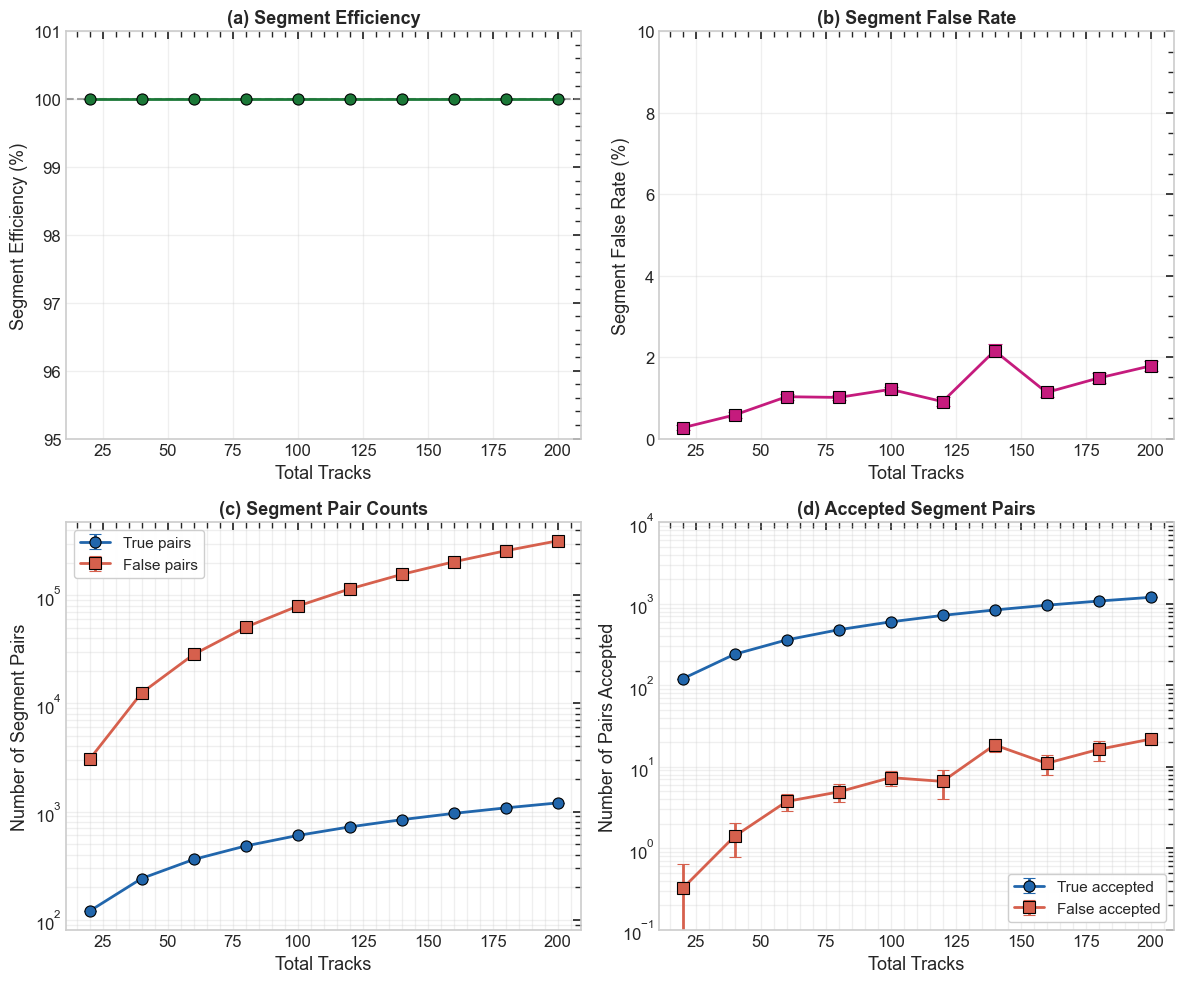

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'axes.linewidth': 1.2,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

if len(segment_efficiency_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Colors
    color_true = '#2166ac'
    color_false = '#d6604d'
    color_eff = '#1b7837'
    color_false_rate = '#c51b7d'
    
    # Extract data
    track_counts = np.array([r['total_tracks'] for r in segment_efficiency_results])
    seg_eff = np.array([r['seg_efficiency'] * 100 for r in segment_efficiency_results])
    false_rate = np.array([r['seg_false_rate'] * 100 for r in segment_efficiency_results])
    n_true = np.array([r['n_true_pairs'] for r in segment_efficiency_results])
    n_false = np.array([r['n_false_pairs'] for r in segment_efficiency_results])
    true_accepted = np.array([r['true_accepted'] for r in segment_efficiency_results])
    false_accepted = np.array([r['false_accepted'] for r in segment_efficiency_results])
    total_accepted = np.array([r['total_accepted'] for r in segment_efficiency_results])
    
    n_true_mean = np.array([r['n_true_mean'] for r in segment_efficiency_results])
    n_true_se = np.array([r['n_true_se'] for r in segment_efficiency_results])
    n_false_mean = np.array([r['n_false_mean'] for r in segment_efficiency_results])
    n_false_se = np.array([r['n_false_se'] for r in segment_efficiency_results])
    true_acc_mean = np.array([r['true_acc_mean'] for r in segment_efficiency_results])
    true_acc_se = np.array([r['true_acc_se'] for r in segment_efficiency_results])
    false_acc_mean = np.array([r['false_acc_mean'] for r in segment_efficiency_results])
    false_acc_se = np.array([r['false_acc_se'] for r in segment_efficiency_results])
    
    # Compute errors
    seg_eff_err = np.sqrt(seg_eff * (100 - seg_eff) / n_true) if np.all(n_true > 0) else np.zeros_like(seg_eff)
    
    false_rate_err = np.zeros_like(false_rate)
    for i, (fa, ta, fr) in enumerate(zip(false_accepted, total_accepted, false_rate)):
        if ta > 0:
            false_rate_err[i] = np.sqrt(fr * (100 - fr) / ta)
    
    # Plot (a): Segment Efficiency
    ax1 = axes[0, 0]
    ax1.errorbar(track_counts, seg_eff, yerr=seg_eff_err, 
                fmt='o-', color=color_eff, capsize=5, capthick=1.5,
                linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=0.8)
    ax1.axhline(100, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    ax1.set_xlabel('Total Tracks', fontsize=13)
    ax1.set_ylabel('Segment Efficiency (%)', fontsize=13)
    ax1.set_title('(a) Segment Efficiency', fontsize=13, fontweight='bold')
    ax1.set_ylim(95, 101)
    ax1.grid(True, alpha=0.3)
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', top=True, right=True)
    
    # Plot (b): False Rate
    ax2 = axes[0, 1]
    ax2.errorbar(track_counts, false_rate, yerr=false_rate_err,
                fmt='s-', color=color_false_rate, capsize=5, capthick=1.5,
                linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=0.8)
    ax2.set_xlabel('Total Tracks', fontsize=13)
    ax2.set_ylabel('Segment False Rate (%)', fontsize=13)
    ax2.set_title('(b) Segment False Rate', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.minorticks_on()
    ax2.tick_params(which='both', direction='in', top=True, right=True)
    ax2.set_ylim(0, 10)
    
    # Plot (c): Pair counts (log scale)
    ax3 = axes[1, 0]
    ax3.errorbar(track_counts, n_true_mean, yerr=n_true_se,
                fmt='o-', color=color_true, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='True pairs')
    ax3.errorbar(track_counts, n_false_mean, yerr=n_false_se,
                fmt='s-', color=color_false, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='False pairs')
    ax3.set_yscale('log')
    ax3.set_xlabel('Total Tracks', fontsize=13)
    ax3.set_ylabel('Number of Segment Pairs', fontsize=13)
    ax3.set_title('(c) Segment Pair Counts', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper left', framealpha=0.95)
    ax3.grid(True, alpha=0.3, which='both')
    ax3.minorticks_on()
    ax3.tick_params(which='both', direction='in', top=True, right=True)
    
    # Plot (d): Accepted pairs (log scale)
    ax4 = axes[1, 1]
    false_acc_plot = np.where(false_acc_mean > 0, false_acc_mean, 0.5)
    false_acc_se_plot = np.where(false_acc_mean > 0, false_acc_se, 0)
    
    ax4.errorbar(track_counts, true_acc_mean, yerr=true_acc_se,
                fmt='o-', color=color_true, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='True accepted')
    ax4.errorbar(track_counts, false_acc_plot, yerr=false_acc_se_plot,
                fmt='s-', color=color_false, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='False accepted')
    ax4.set_yscale('log')
    ax4.set_xlabel('Total Tracks', fontsize=13)
    ax4.set_ylabel('Number of Pairs Accepted', fontsize=13)
    ax4.set_title('(d) Accepted Segment Pairs', fontsize=13, fontweight='bold')
    ax4.legend(loc='lower right', framealpha=0.95)
    ax4.grid(True, alpha=0.3, which='both')
    ax4.minorticks_on()
    ax4.tick_params(which='both', direction='in', top=True, right=True)
    ax4.set_ylim(0.1, 1e4)
    
    plt.tight_layout()
    
    # Save
    output_path = 'plots/fixed_epsilon_segment_efficiency.png'
    pdf_path = 'plots/fixed_epsilon_segment_efficiency.pdf'
    fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    fig.savefig(pdf_path, format='pdf', dpi=600, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    print(f"✓ Saved: {pdf_path}")
    
    plt.show()